In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

from utils import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2022-11-18 11:56:30.635098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 11:56:33.999323: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 11:56:42.059483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib64:/lhome/ext/uv075/uv0753/miniconda3/envs/cuda/lib/:/lhome/ext/uv075/uv0753/miniconda3/envs/cuda/lib/
2022-11-18 11:56:42.060986: W tensorflow/stream_ex

In [2]:
original_perceptnet = PerceptNet(kernel_initializer = 'identity', gdn_kernel_size = 1)
original_perceptnet.compile(optimizer = 'adam', loss = PearsonCorrelation())
original_perceptnet.build(input_shape = (None, 384, 512, 3))

weights_path = tf.keras.utils.get_file(fname = 'perceptnet_rgb.h5',
                                       origin = 'https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')
original_perceptnet.load_weights(weights_path)             
print(original_perceptnet.summary())

2022-11-18 11:57:03.056341: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-18 11:57:03.058958: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mlui01.ific.uv.es
2022-11-18 11:57:03.059898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mlui01.ific.uv.es
2022-11-18 11:57:03.061873: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2022-11-18 11:57:03.062005: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2022-11-18 11:57:03.062031: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2022-11-18 11:57:03.066252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CP

Model: "percept_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   multiple                  8         
                                                                 
 conv2d (Conv2D)             multiple                  12        
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 gdn_1 (GDN)                 multiple                  14        
                                                                 
 conv2d_1 (Conv2D)           multiple                  456       
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                   

In [3]:
tid_path_2013 = '/lustre/ific.uv.es/ml/uv075/Databases/IQA/TID/TID2013'
data_tid_2013 = pd.read_csv(tid_path_2013 + '/image_pairs_mos.csv', index_col = 0)


def train_gen_tid2013():
    for i, row in data_tid_2013.iterrows():
        img = cv2.imread(tid_path_2013 + '/reference_images/' + row.Reference)
        dist_img = cv2.imread(tid_path_2013 + '/distorted_images/' + row.Distorted)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        dist_img = dist_img/255.0
        yield img, dist_img, row.MOS

tid2013_dataset = tf.data.Dataset.from_generator(train_gen_tid2013,
                                                 output_signature=(
                                                 tf.TensorSpec(shape = (384, 512, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape = (384, 512, 3), dtype=tf.float32),
                                                 tf.TensorSpec(shape = (), dtype=tf.float32)))

print(tid2013_dataset)

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [3]:
kadik_path = '/lustre/ific.uv.es/ml/uv075/Databases/IQA/KADIK10K'
data_kadik = pd.read_csv(kadik_path + '/dmos.csv')

def train_gen_kadik():
    for i, row in data_kadik.iterrows():
        img = cv2.imread(kadik_path + '/images/' + row.ref_img)
        dist_img = cv2.imread(kadik_path + '/images/' + row.dist_img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dist_img = cv2.cvtColor(dist_img, cv2.COLOR_BGR2RGB)
        img = img/255.0
        dist_img = dist_img/255.0
        yield img, dist_img, row.dmos

kadik_dataset = tf.data.Dataset.from_generator(train_gen_kadik,
                                               output_signature=(
                                               tf.TensorSpec(shape = (384, 512, 3), dtype  =tf.float32),
                                               tf.TensorSpec(shape = (384, 512, 3), dtype = tf.float32),
                                               tf.TensorSpec(shape = (), dtype = tf.float32)))
print(kadik_dataset)

<FlatMapDataset element_spec=(TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [4]:
kadik_pearson, kadik_spearman = [], []

for i in range(1,len(original_perceptnet.layers)+1):
    model = tf.keras.Sequential(original_perceptnet.layers[0:i])
    model.build(input_shape=(None,384,512,3))
    model.summary()

    mos_kadik, dist_kadik = [], []
    for imgs, dists, mos in kadik_dataset.batch(8):
        mos_kadik.extend(mos)
        preds_img = model(imgs)
        preds_dist = model(dists)
        l2 = (preds_img-preds_dist)**2
        l2 = tf.reduce_sum(l2, axis = [1,2,3])
        l2 = tf.sqrt(l2)
        dist_kadik.extend(l2)
    print(stats.pearsonr(mos_kadik, dist_kadik)[0], stats.spearmanr(mos_kadik, dist_kadik)[0])
    kadik_pearson.append(stats.pearsonr(mos_kadik, dist_kadik)[0])
    kadik_spearman.append(stats.spearmanr(mos_kadik, dist_kadik)[0])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   (None, 384, 512, 3)       8         
                                                                 
Total params: 8
Trainable params: 6
Non-trainable params: 2
_________________________________________________________________


2022-11-18 11:57:06.380948: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55556b4b9f80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-18 11:57:06.380999: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2022-11-18 11:57:06.942230: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [4]:
tid_pearson, tid_spearman = [], []

for i in range(1,len(original_perceptnet.layers)+1):
    model = tf.keras.Sequential(original_perceptnet.layers[0:i])
    model.build(input_shape=(None,384,512,3))
    model.summary()

    mos_tid, dist_tid = [], []
    for imgs, dists, mos in tid2013_dataset.batch(5):
        mos_tid.extend(mos)
        preds_img = model(imgs)
        preds_dist = model(dists)
        l2 = (preds_img-preds_dist)**2
        l2 = tf.reduce_sum(l2, axis = [1,2,3])
        l2 = tf.sqrt(l2)
        dist_tid.extend(l2)
    print(stats.pearsonr(mos_tid, dist_tid)[0], stats.spearmanr(mos_tid, dist_tid)[0])
    tid_pearson.append(stats.pearsonr(mos_tid, dist_tid)[0])
    tid_spearman.append(stats.spearmanr(mos_tid, dist_tid)[0])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   (None, 384, 512, 3)       8         
                                                                 
Total params: 8
Trainable params: 6
Non-trainable params: 2
_________________________________________________________________


2022-11-10 14:28:47.567761: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x561537e83130 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-10 14:28:47.567844: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2022-11-10 14:28:47.655486: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


-0.5939976165511061 -0.6874186442995593
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   (None, 384, 512, 3)       8         
                                                                 
 conv2d (Conv2D)             (None, 384, 512, 3)       12        
                                                                 
Total params: 20
Trainable params: 18
Non-trainable params: 2
_________________________________________________________________
-0.6034374363771112 -0.7018152905810314
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gdn (GDN)                   (None, 384, 512, 3)       8         
                                                                 
 conv2d (Conv2D)             (None, 384, 512, 3)       12        
                      

In [11]:
tid_pearson = [0.598, 0.594, 0.603, 0.594, 0.595, 0.816, 0.814, 0.849, 0.884, 0.920]
tid_spearman = [0.687, 0.687, 0.702, 0.710, 0.714, 0.832, 0.832, 0.869, 0.890, 0.909]

kadik_pearson = [0.550, 0.556, 0.551, 0.556, 0.539, 0.658, 0.659, 0.695, 0.764, 0.805]
kadik_spearman = [0.676, 0.678, 0.677, 0.679, 0.665, 0.771, 0.775, 0.813, 0.830, 0.846]

layers = ['input', 'gdn1', 'conv1', 'max_pool1', 'gdn2', 'conv2', 'max_pool2', 'gdn3', 'conv3', 'gdn4']

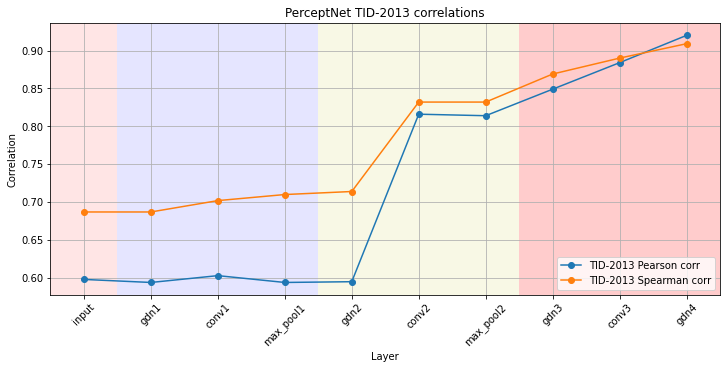

In [17]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.plot(np.arange(10), tid_pearson, '-o', label = 'TID-2013 Pearson corr')
plt.plot(np.arange(10), tid_spearman, '-o', label = 'TID-2013 Spearman corr')
plt.axvspan(-0.5, 0.5, color='r', alpha=0.1, lw=0)
plt.axvspan(0.5, 3.5, color='b', alpha=0.1, lw=0)
plt.axvspan(3.5, 6.5, color='y', alpha=0.1, lw=0)
plt.axvspan(6.5, 10.5, color='r', alpha=0.2, lw=0)
plt.xticks(np.arange(10), layers, rotation = 45)
plt.title('PerceptNet TID-2013 correlations')
plt.xlabel('Layer')
plt.ylabel('Correlation')
#plt.ylim([0.5,1])
plt.xlim([-0.5,9.5])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

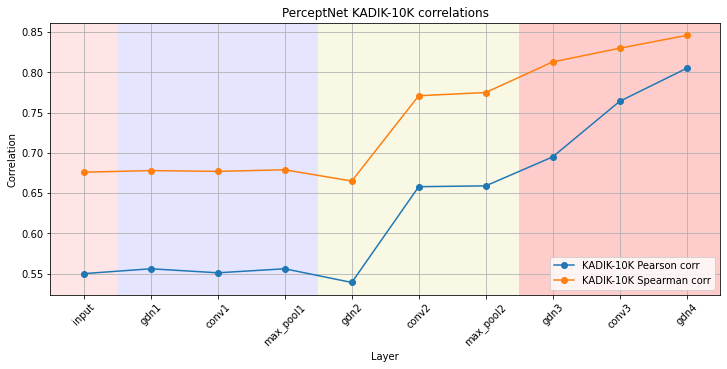

In [18]:
plt.figure(figsize=(12,5), facecolor=(1, 1, 1))
plt.plot(np.arange(10), kadik_pearson, '-o', label = 'KADIK-10K Pearson corr')
plt.plot(np.arange(10), kadik_spearman, '-o', label = 'KADIK-10K Spearman corr')
plt.axvspan(-0.5, 0.5, color='r', alpha=0.1, lw=0)
plt.axvspan(0.5, 3.5, color='b', alpha=0.1, lw=0)
plt.axvspan(3.5, 6.5, color='y', alpha=0.1, lw=0)
plt.axvspan(6.5, 10.5, color='r', alpha=0.2, lw=0)
plt.xticks(np.arange(10), layers, rotation = 45)
plt.title('PerceptNet KADIK-10K correlations')
plt.xlabel('Layer')
plt.ylabel('Correlation')
#plt.ylim([0.5,1])
plt.xlim([-0.5,9.5])
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

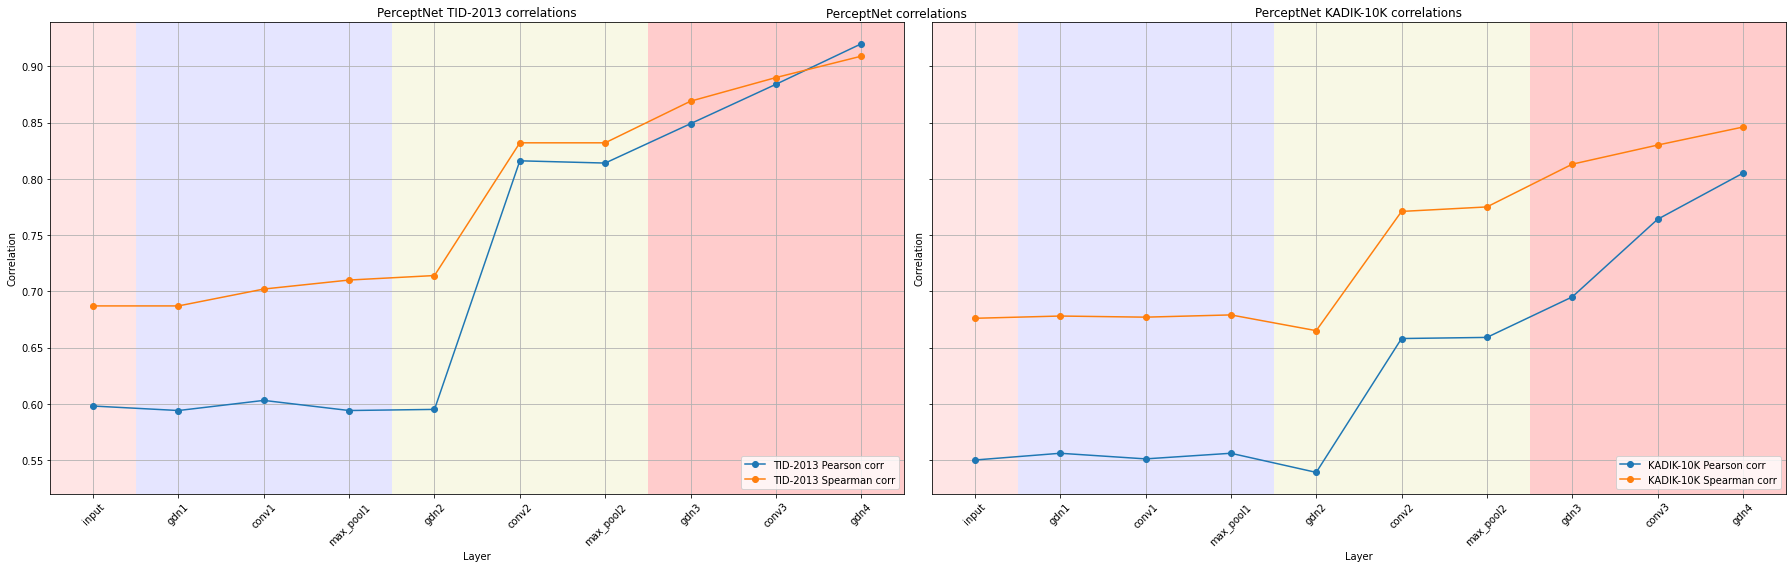

In [20]:
fig, ax = plt.subplots(1,2, sharey=True, figsize = (25,8))
ax[0].plot(np.arange(10), tid_pearson, '-o', label = 'TID-2013 Pearson corr')
ax[0].plot(np.arange(10), tid_spearman, '-o', label = 'TID-2013 Spearman corr')
ax[0].axvspan(-0.5, 0.5, color='r', alpha=0.1, lw=0)
ax[0].axvspan(0.5, 3.5, color='b', alpha=0.1, lw=0)
ax[0].axvspan(3.5, 6.5, color='y', alpha=0.1, lw=0)
ax[0].axvspan(6.5, 10.5, color='r', alpha=0.2, lw=0)
ax[0].set_xticks(np.arange(10), layers, rotation = 45)
ax[0].set_title('PerceptNet TID-2013 correlations')
ax[0].set_xlabel('Layer')
ax[0].set_ylabel('Correlation')
ax[0].set_xlim([-0.5,9.5])
ax[0].legend(loc = 'lower right')
ax[0].grid()

ax[1].plot(np.arange(10), kadik_pearson, '-o', label = 'KADIK-10K Pearson corr')
ax[1].plot(np.arange(10), kadik_spearman, '-o', label = 'KADIK-10K Spearman corr')
ax[1].axvspan(-0.5, 0.5, color='r', alpha=0.1, lw=0)
ax[1].axvspan(0.5, 3.5, color='b', alpha=0.1, lw=0)
ax[1].axvspan(3.5, 6.5, color='y', alpha=0.1, lw=0)
ax[1].axvspan(6.5, 10.5, color='r', alpha=0.2, lw=0)
ax[1].set_xticks(np.arange(10), layers, rotation = 45)
ax[1].set_title('PerceptNet KADIK-10K correlations')
ax[1].set_xlabel('Layer')
ax[1].set_ylabel('Correlation')
ax[1].set_xlim([-0.5,9.5])
ax[1].legend(loc = 'lower right')
ax[1].grid()
fig.tight_layout()
plt.suptitle('PerceptNet correlations')
plt.show()
#plt.savefig('VGG_correlations.png', dpi = 1000)